# Erasmus Neural Networks
http://michalbereta.pl/nn
## Softmax layer


## Before you start

Exacute the examples.

Then, do the tasks and send back the notebook.

Change the name of this notebook according to the schema: {YourSurname}\_{YourFirstName}\_{OriginalFileName}.

Be sure to fill all places with "YOUR ANSWER HERE".

When ready, send the notebook, with all the necessary files zipped, to the teacher.

### Split-validation and Cross-validation

In split-validation the avaiable examples are devided into two sets: the training and the testing set. We train the model on the training set, while the test set is used to actually evaluate the performance of the model.

In cross-validation we use the avaiable data to evaluate, how well our model will perform with data new to it, i.e., not seen during training. In order ot do so, we split the avaiable examples into several training and testing sets in an organized manner.

The usual cross-validation scheme is to splil the data into 10 folds. We train 10 models and average their test performance. For each model, we combine 9 folds to create the training set, while the remaining one is the test set. In each iteration, we use different fold as a the test one. Thus, each example is used exactly once as a testing case.

The final model is prepared by using all examples as training data.

https://en.wikipedia.org/wiki/Cross-validation_(statistics)


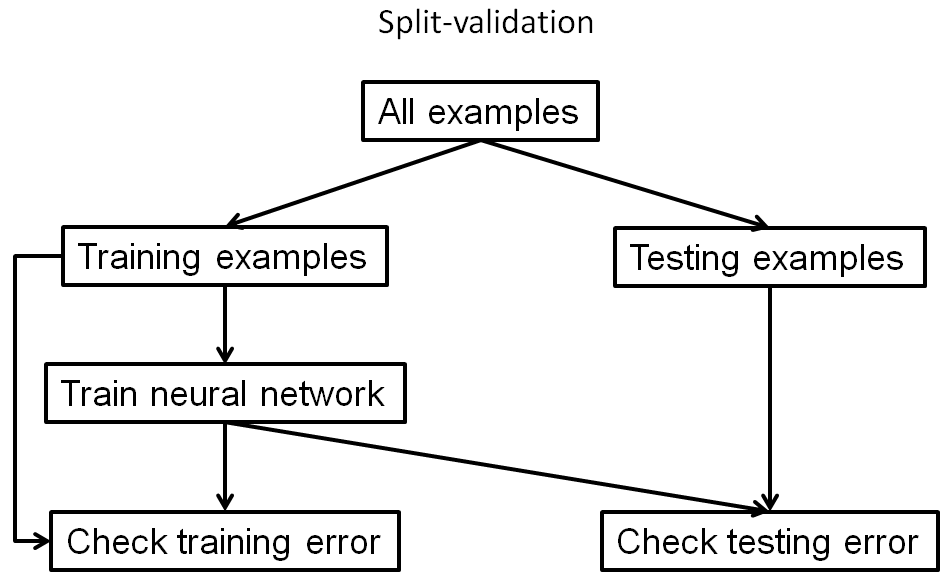

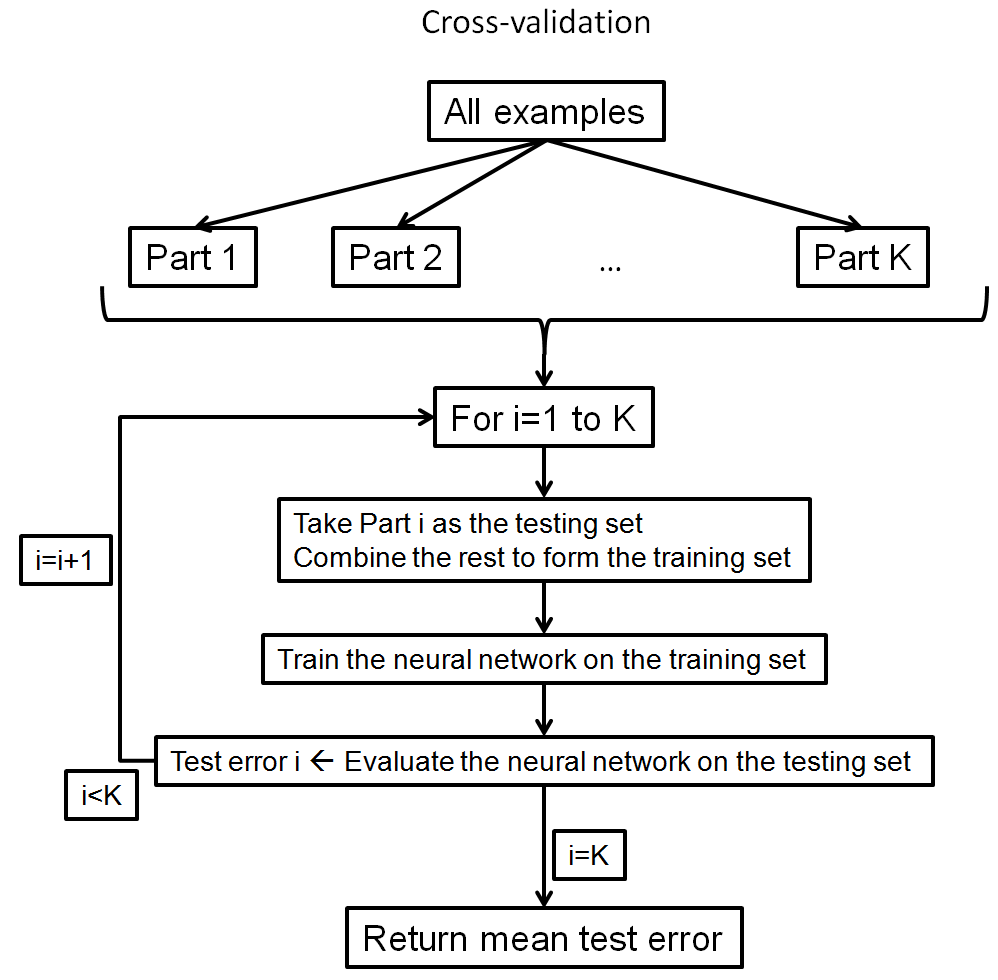

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SoftMaxLinear:
    def __init__(self, inputs_num, outputs_num):
        self.inum = inputs_num
        self.onum = outputs_num
        self.W = (-1 + 2*np.random.rand(inputs_num, outputs_num))/100.0 #neurons as columns
        self.b = np.zeros((1, outputs_num)) #horizontal vector
        self.probs = None
        self.max_epochs = 100
        self.eta_max = 0.1
        self.eta_min = 0.01
    def Forward(self, X): #examples as rows in X
        f = np.dot(X, self.W) + self.b
        f -= np.max(f, axis=1, keepdims=True) #trick for numerical stability
        probs = np.exp(f)
        probs /= np.sum(probs, axis=1, keepdims=True)
        self.probs = probs
    def Test(self, X, ClsIndx):
        self.Forward(X)
        #data loss: mean cross-entropy loss
        ex_num = X.shape[0]
        data_loss = -np.log(self.probs[range(ex_num),ClsIndx]).sum()/ex_num
        #classification error
        predictions = np.argmax(self.probs, axis=1)
        errors_num = np.sum(predictions != ClsIndx)
        error_rate = errors_num / ex_num
        return (data_loss, error_rate, errors_num)
    def GetProbs(self):
        return self.probs
    def GetPredictions(self):
        return np.argmax(self.probs, axis=1)
    def Update(self, X, ClsIndx, lrate):
        self.Forward(X)
        #gradients of outputs (class probabilities)
        ex_num = X.shape[0]
        dprobs = self.probs.copy()
        dprobs[range(ex_num), ClsIndx] -= 1.0
        dprobs /= ex_num #average over all examples
        #gradient of weights and biases
        dW = np.dot(X.T, dprobs) # chain rule to calculate gradients
        db = np.sum(dprobs, axis=0,keepdims=True)
        #update neurons
        self.W = self.W - lrate*dW
        self.b = self.b - lrate*db
    def Learn(self, X, ClsIndx):
        for i in range(self.max_epochs):
            eta = self.eta_max - (self.eta_max - self.eta_min)*float(i)/self.max_epochs
#            print('iteration ',i+1, 'eta=',eta)
            self.Update(X, ClsIndx, eta)       


In [ ]:
def generate_linear_softmax(inputs_num, outputs_num):
    softmax_model = SoftMaxLinear(inputs_num, outputs_num)
    softmax_model.eta_max = 0.1
    softmax_model.eta_min = 0.01
    softmax_model.max_epochs = 200
    return softmax_model

In [ ]:
def split_validation(X, labels, model_generator, split_ratio): 
    '''
    split_ratio - how much of X is used to train the model; 0 < split_ratio < 1
    '''
    print('\nStarting split-validation...')
    ex_num = X.shape[0] #number of examples
    inputs_num = X.shape[1]
    outputs_num = len(set(labels)) #number of classes
    #split data into two parts
    indxs = np.random.rand(ex_num)
    trainX = X[indxs<=split_ratio,:]
    train_labels = labels[indxs<=split_ratio]
    testX = X[indxs>split_ratio,:]
    test_labels = labels[indxs>split_ratio]
    #get the model and train it
    print('Training the model..')
    model = model_generator(inputs_num, outputs_num)
    model.Learn(trainX, train_labels)
    #check the model on train data
    print('Checking the model on train data...')
    model.Forward(trainX)
    ans = model.GetPredictions()
    train_error_rate = (ans!=train_labels).sum()/trainX.shape[0]
    #check the model on test data
    print('Checking the model on test data...')
    model.Forward(testX)
    ans = model.GetPredictions()
    test_error_rate = (ans!=test_labels).sum()/testX.shape[0]
    print('Split-validation finished\n')
    return (train_error_rate, test_error_rate)

In [ ]:
X = np.loadtxt('iris.csv', dtype='str')
#X = np.loadtxt('pima-diabetes.csv', dtype='str', delimiter=',')
    
classes = set(X[:,-1])
for clsname, clsindx in zip(classes, range(len(classes))):
    print(clsname, '-->', clsindx)
    X[X==clsname] = clsindx
labels = X[:,-1].astype('int32')
X = X[:,:-1].astype(np.float)
#print(X)
print(X.shape)
#print(labels)

train_error_rate, test_error_rate = split_validation(X, labels, generate_linear_softmax, 0.7)

print('Results for split-validation:')
print('train_error_rate=', train_error_rate)
print('test_error_rate=', test_error_rate)

In [ ]:
def cross_validation(X, labels, model_generator, num_folds): 
    print('\nStarting cross-validation...')
    ex_num = X.shape[0] #number of examples
    inputs_num = X.shape[1]
    outputs_num = len(set(labels)) #number of classes
    #split data into num_folds parts
    indxs = np.random.randint(num_folds, size=ex_num)
    train_errors = []
    test_errors = []
    for i in range(num_folds):
        #create the current train and test sets
        trainX = X[indxs != i,:]
        train_labels = labels[indxs != i]
        testX = X[indxs == i,:]
        test_labels = labels[indxs == i]
        #get the model and train it
        print('Training model',i+1,'...')
        model = model_generator(inputs_num, outputs_num) #get a new model
        model.Learn(trainX, train_labels)
        #check the model on train data
        print('Checking the model on train data...')
        model.Forward(trainX)
        ans = model.GetPredictions()
        train_error_rate = (ans!=train_labels).sum()/trainX.shape[0]
        #check the model on test data
        print('Checking the model on test data...')
        model.Forward(testX)
        ans = model.GetPredictions()
        test_error_rate = (ans!=test_labels).sum()/testX.shape[0]
        train_errors.append(train_error_rate)
        test_errors.append(test_error_rate)
    train_errors = np.array(train_errors)
    test_errors = np.array(test_errors)
    stats = {}
    stats['train_errors'] = train_errors
    stats['test_errors'] = test_errors
    stats['train_error_mean'] = train_errors.mean()
    stats['test_error_mean'] = test_errors.mean()
    stats['train_error_std'] = train_errors.std()
    stats['test_error_std'] = test_errors.std()
    print('Cross-validation finished\n')
    return stats

In [ ]:
X = np.loadtxt('iris.csv', dtype='str')
#X = np.loadtxt('pima-diabetes.csv', dtype='str', delimiter=',')
    
classes = set(X[:,-1])
for clsname, clsindx in zip(classes, range(len(classes))):
    print(clsname, clsindx)
    X[X==clsname] = clsindx
labels = X[:,-1].astype('int32')
X = X[:,:-1].astype(np.float)
#print(X)
print(X.shape)
#print(labels)

xval = cross_validation(X, labels, generate_linear_softmax, 10)

print('Results for cross-validation:')
for key in xval:
    print(key, xval[key],'')

### Task 1

- Use cross-validation to select the best performing parameters (number of hidden radial neurons and sigma) for RBF network for diabetes dataset.

- Adapt the code of RBF network if necessary to use it with the above functions.

- Prepare a proper model generating function.

- Comment on your results.

#### YOUR ANSWERS HERE
My results are as follows...

In [ ]:
#YOUR CODE HERE